In [110]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, boolean_string
import os

In [9]:
params = yaml.safe_load(open(f'projects/coco.yml'))
obj_list = params['obj_list']

In [10]:
model = EfficientDetBackbone(compound_coef=0, num_classes=len(obj_list),
                            ratios=eval(params['anchors_ratios']), scales=eval(params['anchors_scales']))
model.load_state_dict(torch.load('weights/efficientdet-d0.pth', map_location=torch.device('cpu')))
model.requires_grad_(False)
model.eval()

EfficientDetBackbone(
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
      

In [11]:
regressBoxes = BBoxTransform()
clipBoxes = ClipBoxes()
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
threshold=0.05
nms_threshold=0.5

In [195]:
# image_path = 'IMG_1401.JPG'
image_path = 'insect.jpg'

In [196]:
def objectDetect(image_path):
    ori_imgs, framed_imgs, framed_metas = preprocess(image_path, max_size=input_sizes[0])
    I = torch.from_numpy(framed_imgs[0])
    I = I.float()
    I = I.unsqueeze(0).permute(0, 3, 1, 2)
    features, regression, classification, anchors = model(I)
    preds = postprocess(I, anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, nms_threshold)
    preds = invert_affine(framed_metas, preds)[0]
    scores = preds['scores']
    class_ids = preds['class_ids']
    rois = preds['rois']
    results = []
    if rois.shape[0] > 0:
        # x1,y1,x2,y2 -> x1,y1,w,h
        rois[:, 2] -= rois[:, 0]
        rois[:, 3] -= rois[:, 1]

        bbox_score = scores

        for roi_id in range(rois.shape[0]):
            score = float(bbox_score[roi_id])
            label = int(class_ids[roi_id])
            box = rois[roi_id, :]

            image_result = {
                'category_id': label + 1,
                'score': float(score),
                'bbox': box.tolist(),
            }

            results.append(image_result)
            
    return results

In [197]:
for r in results:
    if r['score'] > 0.0:
        print(f'{r}')

{'category_id': 1, 'score': 0.8388363122940063, 'bbox': [613.1361694335938, 0.07954787462949753, 1022.2616577148438, 3428.9501953125]}
{'category_id': 41, 'score': 0.34579336643218994, 'bbox': [990.3006591796875, 3240.236572265625, 203.808837890625, 761.32080078125]}
{'category_id': 67, 'score': 0.32783153653144836, 'bbox': [2225.35302734375, 2165.248046875, 794.5810546875, 939.571533203125]}
{'category_id': 41, 'score': 0.2691391408443451, 'bbox': [1020.2288208007812, 3242.3115234375, 146.56060791015625, 384.13818359375]}
{'category_id': 62, 'score': 0.20012478530406952, 'bbox': [449.0938720703125, 1386.3338623046875, 323.22576904296875, 833.0172119140625]}
{'category_id': 84, 'score': 0.19383573532104492, 'bbox': [2674.1162109375, 2153.535400390625, 351.416748046875, 212.629150390625]}
{'category_id': 62, 'score': 0.15093962848186493, 'bbox': [472.91302490234375, 1317.364990234375, 253.707763671875, 526.27099609375]}
{'category_id': 72, 'score': 0.10170679539442062, 'bbox': [483.7388

x=855,y=964,w=224,h=179


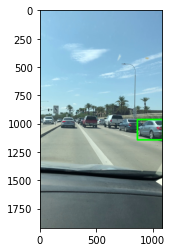

In [198]:
bbox = [855.314697265625, 964.9258422851562, 224.99267578125, 179.77130126953125]
#bbox = [100,100,100,100]
x,y,w,h = np.array(bbox).astype(np.int)
print(f"x={x},y={y},w={w},h={h}")
img = cv2.rectangle(np.float32(ori_imgs[0]), (x,y), (x+w, y+h), (0,255,0), 14)
plt.imshow(img.astype(np.int))

In [202]:
obj_list

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 '',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 '',
 'backpack',
 'umbrella',
 '',
 '',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 '',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 '',
 'dining table',
 '',
 '',
 'toilet',
 '',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 '',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

x=613,y=0,w=1022,h=3428 ==> 1_avi_1614.jpg ==> person


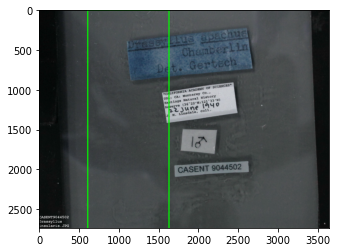

In [201]:
i=0
im = cv2.imread(image_path)
for r in results:
    if r['score'] > 0.5:
        bbox= results[i]['bbox']
        x,y,w,h = np.array(bbox).astype(np.int)
        print(f"x={x},y={y},w={w},h={h} ==>", raw_imageName,'==>',obj_list[results[i]['category_id']-1])
        i += 1
        cv2.putText(im, obj_list[results[i]['category_id']-1],(x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        img = cv2.rectangle(im, (x,y), (x+w, y+h), (0,255,0), 14)
cv2.imwrite('a-output.jpg', img)
plt.imshow(img)

## Read video file and writing frames to folder

In [136]:
# !rm -r /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/*.jpg

In [139]:
KPS = 10 # Target Keyframes Per Second
VIDEO_PATH = "/data/objdet/Yet-Another-EfficientDet-Pytorch/video/" 
VIDEO_NAME = '1.avi'
IMAGE_PATH = "/data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/"  
EXTENSION = ".jpg"

cap = cv2.VideoCapture(VIDEO_PATH + VIDEO_NAME)
# Set frames-per-second for capture
fps = round(cap.get(cv2.CAP_PROP_FPS))
hop = round(fps / KPS)
curr_frame = 0
while(True):
    ret, frame = cap.read()
    if not ret: break
    if curr_frame % hop == 0:
        name = IMAGE_PATH + VIDEO_NAME.replace('.',"_") + "_" + str(curr_frame).zfill(4) + EXTENSION
        print('Creating... {0}'.format(name,))
        cv2.imwrite(name, frame)
    curr_frame += 1
print ('# of frames:', curr_frame)
cap.release()

Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0000.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0006.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0012.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0018.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0024.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0030.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0036.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0042.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0048.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0054.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0060.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pyto

Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0576.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0582.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0588.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0594.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0600.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0606.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0612.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0618.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0624.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0630.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_0636.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pyto

Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1152.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1158.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1164.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1170.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1176.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1182.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1188.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1194.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1200.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1206.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/1_avi_1212.jpg
Creating... /data/objdet/Yet-Another-EfficientDet-Pyto

In [137]:
# !rm -r /data/objdet/Yet-Another-EfficientDet-Pytorch/video-imageP/*.jpg

## Loop through the video images and create bounding boxes for objects

In [176]:
RAW_IMAGE_PATH = "/data/objdet/Yet-Another-EfficientDet-Pytorch/video-image2/"  
PROCESSED_IMAGE_PATH = "/data/objdet/Yet-Another-EfficientDet-Pytorch/video-imageP/"  
EXTENSION = ".jpg"

files = [f for f in os.listdir(RAW_IMAGE_PATH)]
files.sort(key = lambda x: int(x.split('.')[0].split('_')[-1]))
# files_subset = files[:100]

for raw_imageName in files:
    boundingbox_filename = PROCESSED_IMAGE_PATH + raw_imageName.split('.')[0] + "_P" + EXTENSION
    results = objectDetect(RAW_IMAGE_PATH+ raw_imageName)
    im = cv2.imread(RAW_IMAGE_PATH+ raw_imageName)
    i=0
    for r in results:
        if r['score'] > 0.5:
            bbox= results[i]['bbox']
            x,y,w,h = np.array(bbox).astype(np.int)
            print(f"x={x},y={y},w={w},h={h} ==>", raw_imageName,'==>',obj_list[results[i]['category_id']-1])
            cv2.putText(im, obj_list[results[i]['category_id']-1],(x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
            i += 1
            img = cv2.rectangle(im, (x,y), (x+w, y+h), (0,255,0), 10)
            
    cv2.imwrite(boundingbox_filename, img)

x=506,y=1008,w=149,h=100 ==> 1_avi_0000.jpg ==> car
x=12,y=1427,w=1081,h=464 ==> 1_avi_0000.jpg ==> car
x=13,y=1448,w=1078,h=436 ==> 1_avi_0006.jpg ==> car
x=500,y=1013,w=146,h=99 ==> 1_avi_0006.jpg ==> car
x=14,y=1468,w=1075,h=418 ==> 1_avi_0012.jpg ==> car
x=501,y=1019,w=144,h=97 ==> 1_avi_0012.jpg ==> car
x=493,y=1022,w=146,h=98 ==> 1_avi_0018.jpg ==> car
x=14,y=1461,w=1075,h=423 ==> 1_avi_0018.jpg ==> car
x=488,y=1022,w=146,h=100 ==> 1_avi_0024.jpg ==> car
x=11,y=1459,w=1079,h=426 ==> 1_avi_0024.jpg ==> car
x=488,y=1022,w=138,h=96 ==> 1_avi_0030.jpg ==> car
x=479,y=1022,w=140,h=96 ==> 1_avi_0036.jpg ==> car
x=477,y=1019,w=136,h=98 ==> 1_avi_0042.jpg ==> car
x=476,y=1017,w=130,h=92 ==> 1_avi_0048.jpg ==> car
x=9,y=1446,w=1080,h=439 ==> 1_avi_0048.jpg ==> car
x=12,y=1445,w=1074,h=441 ==> 1_avi_0054.jpg ==> car
x=472,y=1007,w=134,h=94 ==> 1_avi_0054.jpg ==> car
x=13,y=1431,w=1075,h=458 ==> 1_avi_0060.jpg ==> car
x=468,y=1001,w=132,h=93 ==> 1_avi_0060.jpg ==> car
x=461,y=990,w=127,h=97

x=916,y=1024,w=145,h=90 ==> 1_avi_0618.jpg ==> car
x=93,y=997,w=148,h=97 ==> 1_avi_0618.jpg ==> car
x=15,y=1388,w=1068,h=522 ==> 1_avi_0618.jpg ==> car
x=927,y=1023,w=152,h=92 ==> 1_avi_0624.jpg ==> car
x=14,y=1394,w=1066,h=516 ==> 1_avi_0624.jpg ==> car
x=59,y=1001,w=179,h=100 ==> 1_avi_0624.jpg ==> car
x=948,y=1019,w=133,h=96 ==> 1_avi_0630.jpg ==> car
x=12,y=1392,w=1069,h=519 ==> 1_avi_0630.jpg ==> car
x=9,y=1018,w=171,h=93 ==> 1_avi_0630.jpg ==> car
x=961,y=1013,w=119,h=94 ==> 1_avi_0636.jpg ==> car
x=1,y=1010,w=163,h=103 ==> 1_avi_0636.jpg ==> car
x=11,y=1325,w=1073,h=582 ==> 1_avi_0636.jpg ==> car
x=1,y=997,w=103,h=121 ==> 1_avi_0642.jpg ==> car
x=82,y=984,w=123,h=82 ==> 1_avi_0642.jpg ==> car
x=968,y=1015,w=112,h=89 ==> 1_avi_0642.jpg ==> car
x=5,y=1155,w=1095,h=754 ==> 1_avi_0642.jpg ==> car
x=12,y=1346,w=1068,h=564 ==> 1_avi_0648.jpg ==> car
x=24,y=976,w=158,h=86 ==> 1_avi_0648.jpg ==> car
x=960,y=1006,w=121,h=94 ==> 1_avi_0648.jpg ==> car
x=11,y=1357,w=1067,h=555 ==> 1_avi_06

x=843,y=977,w=238,h=167 ==> 1_avi_0894.jpg ==> car
x=664,y=986,w=135,h=83 ==> 1_avi_0894.jpg ==> car
x=10,y=1347,w=1074,h=564 ==> 1_avi_0894.jpg ==> car
x=279,y=966,w=115,h=82 ==> 1_avi_0894.jpg ==> car
x=852,y=966,w=229,h=176 ==> 1_avi_0900.jpg ==> car
x=14,y=1337,w=1067,h=575 ==> 1_avi_0900.jpg ==> car
x=270,y=958,w=117,h=80 ==> 1_avi_0900.jpg ==> car
x=669,y=975,w=135,h=84 ==> 1_avi_0900.jpg ==> car
x=14,y=1325,w=1068,h=585 ==> 1_avi_0906.jpg ==> car
x=861,y=960,w=220,h=181 ==> 1_avi_0906.jpg ==> car
x=675,y=966,w=135,h=87 ==> 1_avi_0906.jpg ==> car
x=266,y=953,w=116,h=80 ==> 1_avi_0906.jpg ==> car
x=393,y=939,w=112,h=76 ==> 1_avi_0906.jpg ==> car
x=868,y=955,w=215,h=186 ==> 1_avi_0912.jpg ==> car
x=670,y=960,w=143,h=91 ==> 1_avi_0912.jpg ==> car
x=6,y=1298,w=1082,h=611 ==> 1_avi_0912.jpg ==> car
x=258,y=943,w=111,h=83 ==> 1_avi_0912.jpg ==> car
x=392,y=934,w=107,h=79 ==> 1_avi_0912.jpg ==> car
x=880,y=953,w=204,h=195 ==> 1_avi_0918.jpg ==> car
x=670,y=958,w=151,h=96 ==> 1_avi_0918.

x=486,y=840,w=191,h=148 ==> 1_avi_1080.jpg ==> car
x=267,y=864,w=134,h=102 ==> 1_avi_1080.jpg ==> car
x=790,y=817,w=292,h=206 ==> 1_avi_1080.jpg ==> car
x=7,y=1226,w=1074,h=689 ==> 1_avi_1080.jpg ==> car
x=268,y=867,w=134,h=104 ==> 1_avi_1086.jpg ==> car
x=484,y=841,w=193,h=153 ==> 1_avi_1086.jpg ==> car
x=809,y=821,w=271,h=209 ==> 1_avi_1086.jpg ==> car
x=9,y=1243,w=1068,h=672 ==> 1_avi_1086.jpg ==> car
x=268,y=870,w=138,h=106 ==> 1_avi_1092.jpg ==> car
x=9,y=1255,w=1070,h=660 ==> 1_avi_1092.jpg ==> car
x=830,y=822,w=252,h=218 ==> 1_avi_1092.jpg ==> car
x=496,y=843,w=188,h=153 ==> 1_avi_1092.jpg ==> car
x=498,y=847,w=199,h=156 ==> 1_avi_1098.jpg ==> car
x=269,y=872,w=139,h=106 ==> 1_avi_1098.jpg ==> car
x=8,y=1258,w=1069,h=657 ==> 1_avi_1098.jpg ==> car
x=849,y=826,w=231,h=223 ==> 1_avi_1098.jpg ==> car
x=496,y=848,w=213,h=163 ==> 1_avi_1104.jpg ==> car
x=267,y=874,w=141,h=107 ==> 1_avi_1104.jpg ==> car
x=871,y=829,w=212,h=224 ==> 1_avi_1104.jpg ==> car
x=5,y=1255,w=1075,h=660 ==> 1_a

x=578,y=831,w=282,h=225 ==> 1_avi_1320.jpg ==> car
x=463,y=868,w=118,h=94 ==> 1_avi_1320.jpg ==> car
x=7,y=1248,w=1082,h=662 ==> 1_avi_1320.jpg ==> car
x=260,y=868,w=149,h=113 ==> 1_avi_1320.jpg ==> car
x=37,y=857,w=133,h=88 ==> 1_avi_1320.jpg ==> car
x=9,y=1256,w=1077,h=654 ==> 1_avi_1326.jpg ==> car
x=582,y=832,w=280,h=220 ==> 1_avi_1326.jpg ==> car
x=26,y=854,w=134,h=94 ==> 1_avi_1326.jpg ==> car
x=263,y=866,w=146,h=115 ==> 1_avi_1326.jpg ==> car
x=471,y=869,w=111,h=91 ==> 1_avi_1326.jpg ==> car
x=583,y=831,w=281,h=222 ==> 1_avi_1332.jpg ==> car
x=9,y=1251,w=1078,h=659 ==> 1_avi_1332.jpg ==> car
x=7,y=855,w=144,h=97 ==> 1_avi_1332.jpg ==> car
x=265,y=865,w=145,h=114 ==> 1_avi_1332.jpg ==> car
x=468,y=866,w=115,h=93 ==> 1_avi_1332.jpg ==> car
x=583,y=832,w=285,h=222 ==> 1_avi_1338.jpg ==> car
x=8,y=1255,w=1079,h=657 ==> 1_avi_1338.jpg ==> car
x=473,y=866,w=111,h=93 ==> 1_avi_1338.jpg ==> car
x=266,y=866,w=148,h=112 ==> 1_avi_1338.jpg ==> car
x=1,y=853,w=139,h=105 ==> 1_avi_1338.jpg =

x=12,y=1308,w=1068,h=600 ==> 1_avi_1566.jpg ==> car
x=264,y=891,w=218,h=176 ==> 1_avi_1566.jpg ==> car
x=558,y=867,w=181,h=148 ==> 1_avi_1566.jpg ==> car
x=906,y=902,w=178,h=64 ==> 1_avi_1566.jpg ==> car
x=11,y=1315,w=1070,h=595 ==> 1_avi_1572.jpg ==> car
x=265,y=897,w=221,h=179 ==> 1_avi_1572.jpg ==> car
x=564,y=872,w=171,h=141 ==> 1_avi_1572.jpg ==> car
x=917,y=909,w=164,h=61 ==> 1_avi_1572.jpg ==> car
x=12,y=1309,w=1069,h=600 ==> 1_avi_1578.jpg ==> car
x=264,y=895,w=227,h=184 ==> 1_avi_1578.jpg ==> car
x=567,y=874,w=169,h=140 ==> 1_avi_1578.jpg ==> car
x=929,y=912,w=153,h=63 ==> 1_avi_1578.jpg ==> car
x=12,y=1306,w=1070,h=603 ==> 1_avi_1584.jpg ==> car
x=266,y=898,w=243,h=187 ==> 1_avi_1584.jpg ==> car
x=571,y=878,w=167,h=133 ==> 1_avi_1584.jpg ==> car
x=941,y=909,w=138,h=66 ==> 1_avi_1584.jpg ==> car
x=269,y=896,w=247,h=192 ==> 1_avi_1590.jpg ==> car
x=12,y=1294,w=1071,h=616 ==> 1_avi_1590.jpg ==> car
x=573,y=880,w=168,h=132 ==> 1_avi_1590.jpg ==> car
x=960,y=913,w=121,h=64 ==> 1_a

# Create Video from all combine images

In [177]:
import glob

img_array = []
PROCESSED_IMAGE_PATH = "/data/objdet/Yet-Another-EfficientDet-Pytorch/video-imageP/"  

for filename in glob.glob(PROCESSED_IMAGE_PATH + '*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

x=613,y=0,w=1022,h=3428 ==> person


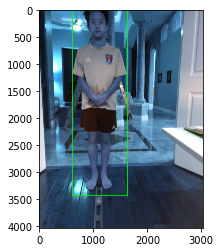

In [189]:
results= objectDetect('aa.jpg')
i=0
im = cv2.imread('aa.jpg')
for r in results:
    if r['score'] > 0.5:
        bbox= results[i]['bbox']
        x,y,w,h = np.array(bbox).astype(np.int)
        print(f"x={x},y={y},w={w},h={h}",'==>',obj_list[results[i]['category_id']-1])
        i += 1
        cv2.putText(im, obj_list[results[i]['category_id']-1],(x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        img = cv2.rectangle(im, (x,y), (x+w, y+h), (0,255,0), 14)
cv2.imwrite('aaa-output.jpg', img)
plt.imshow(img)

In [ ]:
20inch

depth 47.75inches

In [181]:
x=613
y=0
w=1022
h=3428

FOCAL_LENGTH = 28
KNOWN_HEIGHT = 2

KNOWN_HEIGHT * FOCAL_LENGTH / x

0.19444444444444445

In [ ]:

def distance_to_camera():
    return (KNOWN_HEIGHT * FOCAL_LENGTH) / 